In [1]:
from openbb_terminal.sdk import openbb
from libs.backtester import Backtester
from backtesting import Strategy
from backtesting.lib import crossover
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

In [2]:
start_date = '1999-01-01'
end_date = '2001-01-01'
price_qqq = openbb.stocks.load('QQQ', start_date=start_date, end_date=end_date)
t10y = openbb.economy.treasury(maturity=['10y'], start_date=start_date, end_date=end_date)
t1y = openbb.economy.treasury(maturity=['1y'], start_date=start_date, end_date=end_date)
price_qqq[ price_qqq['Close'] != price_qqq['Adj Close']]

Loading Daily data for QQQ with starting period 1999-03-10.

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
date,,,,,,,,


In [3]:
openbb.stocks.candle('QQQ', start_date=start_date, end_date=end_date)
openbb.economy.treasury_chart(maturities=['1y'], start_date=start_date, end_date=end_date)

Loading Daily data for QQQ with starting period 1999-03-10.

In [4]:
df = pd.merge(price_qqq, t1y, how='inner', left_index=True, right_index=True)
df['Returns'] = df['Close'] - df['Open']
df['Return From T0'] = ( df['Close'] / df['Open'].iloc[0] ) - 1
df['1y'] = pd.to_numeric(df['1y'], errors='coerce').fillna(0)
df['1y Pct'] = df['1y'] / 100.0
df['Excess Return'] = df['Return From T0'] - df['1y Pct']
df['Sharpe'] = df['Excess Return'] / df['Returns'].expanding().std()
ema_a = 5
ema_b = 20
df[f'Sharpe Ema {ema_a}'] = ta.ema(df['Sharpe'], ema_a).fillna(0)
df[f'Sharpe Ema {ema_b}'] = ta.ema(df['Sharpe'], ema_b).fillna(0)
df

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,1y,Returns,Return From T0,1y Pct,Excess Return,Sharpe,Sharpe Ema 5,Sharpe Ema 20
date,,,,,,,,,,,,,,,,
1999-03-10,43.600711,43.627361,42.881139,43.547409,43.547409,5232000,0.0,0.0,4.75,-0.053302,-0.001222,0.0475,-0.048722,NaN,0.000000,0.000000
1999-03-11,43.867204,44.120387,42.907776,43.760601,43.760601,9688600,0.0,0.0,4.77,-0.106603,0.003667,0.0477,-0.044033,-1.168293,0.000000,0.000000
1999-03-12,43.600696,43.627346,42.348108,42.694569,42.694569,8743600,0.0,0.0,4.76,-0.906127,-0.020783,0.0476,-0.068383,-0.143139,0.000000,0.000000
1999-03-15,43.014379,43.973807,42.561315,43.920506,43.920506,6369000,0.0,0.0,4.76,0.906127,0.007335,0.0476,-0.040265,-0.054295,0.000000,0.000000
1999-03-16,44.107077,44.480188,43.627362,44.293633,44.293633,4905800,0.0,0.0,4.74,0.186556,0.015892,0.0474,-0.031508,-0.048459,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-22,49.144059,51.809138,49.037456,51.595932,51.595932,57240000,0.0,0.0,5.25,2.451873,0.183374,0.0525,0.130874,0.069287,0.060588,0.115050
2000-12-26,51.675895,52.808554,49.463879,51.915752,51.915752,37082800,0.0,0.0,5.31,0.239857,0.190709,0.0531,0.137609,0.072930,0.064702,0.111039
2000-12-27,50.903016,53.035080,50.263397,52.502064,52.502064,33955500,0.0,0.0,5.32,1.599048,0.204156,0.0532,0.150956,0.080018,0.069807,0.108084


<Axes: xlabel='date'>

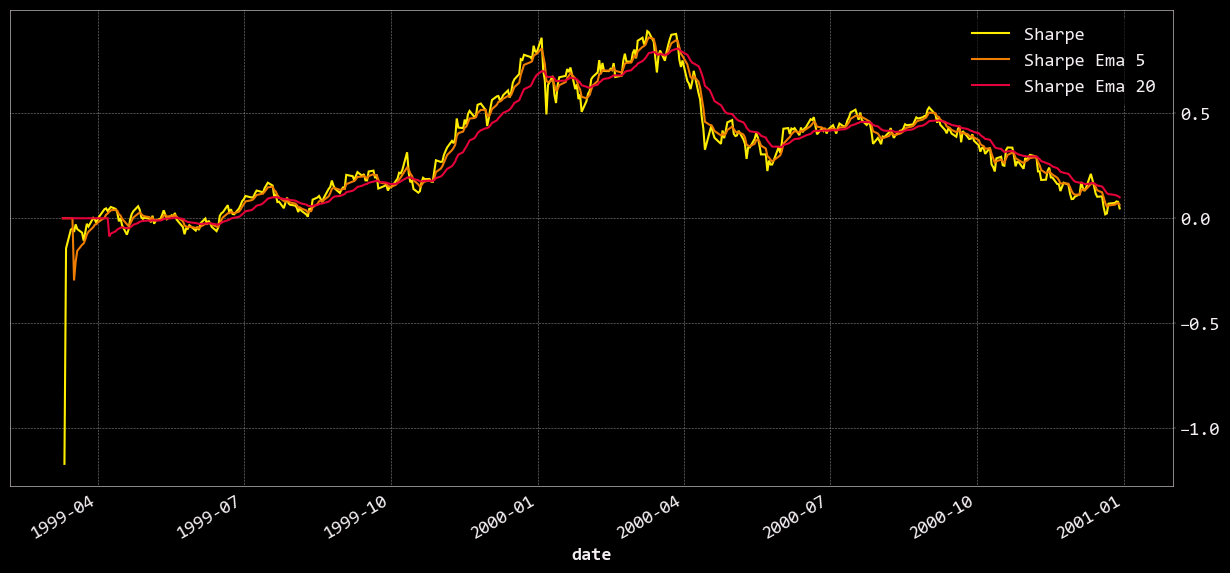

In [5]:
df[['Sharpe', f'Sharpe Ema {ema_a}', f'Sharpe Ema {ema_b}']].plot()

In [6]:
df[f'Sharpe Signal {ema_a}'] = ( df[f'Sharpe Ema {ema_a}'] - df['Sharpe'] ).apply(lambda v: v if v > 0 else 0)
df[f'Sharpe Signal {ema_b}'] = ( df[f'Sharpe Ema {ema_b}'] - df['Sharpe'] ).apply(lambda v: v if v > 0 else 0)

def crossover_signal(A, B):
    signals = []
    for i, (a, b) in enumerate( zip(A, B) ):
        signal = 0
        if i > 0 and a < b and A[i-1] > B[i-1]:
            signal = 1 * (a+b)/2.0
        signals.append(signal)
    return signals

df['Sharpe Signal'] = crossover_signal(df[f'Sharpe Signal {ema_a}'].values, df[f'Sharpe Signal {ema_b}'].values)
df

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,1y,Returns,Return From T0,1y Pct,Excess Return,Sharpe,Sharpe Ema 5,Sharpe Ema 20,Sharpe Signal 5,Sharpe Signal 20,Sharpe Signal
date,,,,,,,,,,,,,,,,,,,
1999-03-10,43.600711,43.627361,42.881139,43.547409,43.547409,5232000,0.0,0.0,4.75,-0.053302,-0.001222,0.0475,-0.048722,NaN,0.000000,0.000000,0.000000,0.000000,0.0
1999-03-11,43.867204,44.120387,42.907776,43.760601,43.760601,9688600,0.0,0.0,4.77,-0.106603,0.003667,0.0477,-0.044033,-1.168293,0.000000,0.000000,1.168293,1.168293,0.0
1999-03-12,43.600696,43.627346,42.348108,42.694569,42.694569,8743600,0.0,0.0,4.76,-0.906127,-0.020783,0.0476,-0.068383,-0.143139,0.000000,0.000000,0.143139,0.143139,0.0
1999-03-15,43.014379,43.973807,42.561315,43.920506,43.920506,6369000,0.0,0.0,4.76,0.906127,0.007335,0.0476,-0.040265,-0.054295,0.000000,0.000000,0.054295,0.054295,0.0
1999-03-16,44.107077,44.480188,43.627362,44.293633,44.293633,4905800,0.0,0.0,4.74,0.186556,0.015892,0.0474,-0.031508,-0.048459,0.000000,0.000000,0.048459,0.048459,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-22,49.144059,51.809138,49.037456,51.595932,51.595932,57240000,0.0,0.0,5.25,2.451873,0.183374,0.0525,0.130874,0.069287,0.060588,0.115050,0.000000,0.045763,0.0
2000-12-26,51.675895,52.808554,49.463879,51.915752,51.915752,37082800,0.0,0.0,5.31,0.239857,0.190709,0.0531,0.137609,0.072930,0.064702,0.111039,0.000000,0.038108,0.0
2000-12-27,50.903016,53.035080,50.263397,52.502064,52.502064,33955500,0.0,0.0,5.32,1.599048,0.204156,0.0532,0.150956,0.080018,0.069807,0.108084,0.000000,0.028066,0.0


In [7]:
df['Sharpe below'] = (df['Sharpe Ema 20'] - df['Sharpe']).apply(lambda v: v if v > 0 else 0)

In [8]:
def extract(df, column):
    return df[column]

class Alpha1(Strategy):
    NAME = 'alpha 1'
    
    def init(self):
        super().init()
        self.sharpe_signal = self.I(extract, df=self.data, column=f'Sharpe Signal')
        self.vwma_5d = self.I(ta.vwma, close=self.data.df['Close'], volume=self.data.df['Volume'], length=5, overlay=True)
        self.vwma_20d = self.I(ta.vwma, close=self.data.df['Close'], volume=self.data.df['Volume'], length=20, overlay=True)
        
    def next(self):
        super().next()
        
                
bt = Backtester(strategy=Alpha1, data=df, capital=100_000, commission=0.00)
bt.run()

Start                     1999-03-10 00:00:00
End                       2000-12-29 00:00:00
Duration                    660 days 00:00:00
Exposure Time [%]                         0.0
Equity Final [$]                      10000.0
Equity Peak [$]                       10000.0
Return [%]                                0.0
Buy & Hold Return [%]               14.320665
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

In [9]:
def crossover_signal(A, B):
    signals = []
    for i, (a, b) in enumerate( zip(A, B) ):
        signal = 0
        if i > 0 and a < b and A[i-1] > B[i-1]:
            signal = 1 * (a+b)/2.0
        signals.append(signal)
    return signals

def sharpe_drawdown_crossing_indicator(df, window, smoothing_a, smoothing_b):
    sharpe = openbb.qa.sharpe(df['Close'], window=window)
    rolling_max = df['High'].rolling(window, min_periods=1).max()
    drawdown = (df['High']/rolling_max) - 1.0
    sharpe_drawdown = (sharpe * drawdown).apply(lambda v: v if v > 0 else 0)
    sharpe_drawdown_a = ta.sma(sharpe_drawdown, length=smoothing_a)
    sharpe_drawdown_b = ta.sma(sharpe_drawdown, length=smoothing_b)
    return crossover_signal(sharpe_drawdown_a.values, sharpe_drawdown_b.values)
    # TODO: if past 5 days has signal go again
    # TODO: if past 10 days has trades closed due to Low price, and vwaps cross, go again
    

def _sharpe_rsi_drawdown(df, window):
    sharpe = openbb.qa.sharpe(df['Close'], window=window)
    rsi = ta.rsi(close=df['Close'], length=window)
    rolling_max = rsi.rolling(30, min_periods=1).max()
    rsi_drawdown = (rsi/rolling_max) - 1.0
    sharpe_rsi_drawdown = (sharpe * rsi_drawdown).apply(lambda v: v if v > 0 else 0)
    return sharpe_rsi_drawdown
    
def sharpe_rsi_drawdown_crossing_indicator(df, window, smoothing_a, smoothing_b):
    sharpe_rsi_drawdown = _sharpe_rsi_drawdown(df=df, window=window)
    sharpe_rsi_drawdown_sma_a = ta.sma(sharpe_rsi_drawdown, length=smoothing_a)
    sharpe_rsi_drawdown_sma_b = ta.sma(sharpe_rsi_drawdown, length=smoothing_b)
    return crossover_signal(sharpe_rsi_drawdown_sma_a.values, sharpe_rsi_drawdown_sma_b.values)

def rolling_stddev(df, window):
    return df['Close'].rolling(window).std()

def stoploss_line(df, window, tolerance):
    stddev = rolling_stddev(df, window)
    offset = (1.0 + tolerance) * stddev
    return df['Low'] - offset

def vwapma_line(df, length):
    vwap = ta.vwap(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'])
    return ta.sma(vwap, length=length)

class TQQQStrategy(Strategy):
    NAME = 'tqqq strategy'
    BUY_SIGNAL_THRESHOLD = 0.001
    STOPLOSS_TOLERANCE = 0.05
    
    def init(self):
        super().init()
        self.sharpe_drawdown_crossing = self.I(sharpe_rsi_drawdown_crossing_indicator, df=self.data.df, window=30, smoothing_a=10, smoothing_b=15)
        #self.b = self.I(sharpe_drawdown_crossing_indicator, df=self.data.df, window=30, smoothing_a=5, smoothing_b=15)
        # self.vwma_5d = self.I(ta.vwma, close=self.data.df['Close'], volume=self.data.df['Volume'], length=5, overlay=True)
        # self.vwma_20d = self.I(ta.vwma, close=self.data.df['Close'], volume=self.data.df['Volume'], length=20, overlay=True)
        self.vwma_5d = self.I(vwapma_line, df=self.data.df, length=5, overlay=True)
        self.vwma_20d = self.I(vwapma_line, df=self.data.df, length=10, overlay=True)
        self.stddev = self.I(rolling_stddev, df=self.data.df, window=30)
        self.stoploss = self.I(stoploss_line, df=self.data.df, window=30, tolerance=self.STOPLOSS_TOLERANCE, overlay=True)
        #self.roc = self.I(ta.roc, close=self.data.df['Close'], length=1)
        self.signal_count = 0
        
    def _signal_flag(self, flag, n=1):
        signal_off = not flag
        is_nth_signal = flag and self.signal_count == n
        return signal_off or is_nth_signal
    
    def _market_trading_down(self):
        vmwa_below = self.vwma_5d[-1] < self.vwma_20d[-1]
        open_below_vmwa = self.data.Open[-1] < self.vwma_5d[-1]
        close_below_vmwa = self.data.Close[-1] < self.vwma_5d[-1]
        return vmwa_below and close_below_vmwa #and open_below_vmwa
        
    def next(self):
        super().next()
        if self.position.size > 0:
            for trades in self.trades:
                trade_stoploss = trades.sl
                stoploss_t0 = self.stoploss[-1]
                trades.sl = max(trade_stoploss, stoploss_t0)
            
        signal = self.sharpe_drawdown_crossing[-1]
        max_signal_past_20d = max(self.sharpe_drawdown_crossing[-5:-1]) # past 10 days
        signal_memory_condition = False#not self._market_trading_down() and max_signal_past_20d >= self.BUY_SIGNAL_THRESHOLD > 0
        has_signal = signal >= self.BUY_SIGNAL_THRESHOLD or (self.position.size == 0 and signal_memory_condition)
        if has_signal:
            self.signal_count += 1
            if self._signal_flag(False):
                sl = self.stoploss[-1]
                self.buy(sl=sl, size=0.4)
            
            
#bt = Backtester(strategy=TQQQStrategy, data=openbb.stocks.load('TQQQ', start_date='2010-01-01', end_date='2012-01-01'), capital=10000, commission=0.002)
bt = Backtester(strategy=TQQQStrategy, data=openbb.stocks.load('QQQ', start_date='1995-01-01', end_date='2005-01-01'), capital=10000, commission=0.002)
stats = bt.run()


Loading Daily data for QQQ with starting period 1999-03-10.